Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [13]:
# Logistic Model

batch_size = 128

graph = tf.Graph()
with graph.as_default():
    
    # Inputs
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    reg = tf.placeholder(tf.float32)
    
    # Variables
    weights = tf.Variable(
        tf.truncated_normal([image_size*image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training Computation
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + reg*tf.nn.l2_loss(weights)
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
     # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [14]:
num_steps= 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, reg: 1e-3}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 22.258760
Minibatch accuracy: 7.8%
Validation accuracy: 10.0%
Minibatch loss at step 500: 3.004976
Minibatch accuracy: 73.4%
Validation accuracy: 75.8%
Minibatch loss at step 1000: 1.915320
Minibatch accuracy: 74.2%
Validation accuracy: 78.6%
Minibatch loss at step 1500: 1.207780
Minibatch accuracy: 80.5%
Validation accuracy: 80.0%
Minibatch loss at step 2000: 1.002489
Minibatch accuracy: 82.0%
Validation accuracy: 80.9%
Minibatch loss at step 2500: 0.832931
Minibatch accuracy: 82.8%
Validation accuracy: 81.4%
Minibatch loss at step 3000: 0.790169
Minibatch accuracy: 76.6%
Validation accuracy: 81.3%
Test accuracy: 88.6%


In [36]:
"""Let us plot the accuracy for various values of regularization"""
import numpy as np
import sys
num_steps = 3001
reg_vals = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
acc_val = []

for reg_i in reg_vals:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, reg: reg_i}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        acc_val.append(accuracy(test_prediction.eval(), test_labels))
print(len(acc_val))

20


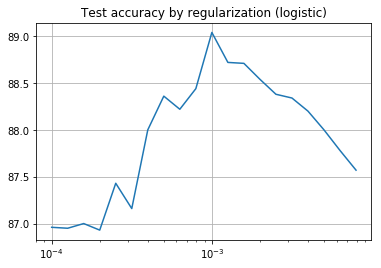

In [37]:
from matplotlib import pyplot as plt
plt.semilogx(reg_vals, acc_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

__Conclusion__: A regularization value of 1e-3 provides the best accuracy.

In [40]:
# Neural Network
batch_size = 128
n_hidden = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    reg = tf.placeholder(tf.float32)
    
    # Variables
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, n_hidden]))
    biases1 = tf.Variable(tf.zeros([n_hidden]))
    weights2 = tf.Variable(
        tf.truncated_normal([n_hidden, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation
    hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(hidden, weights2) + biases2
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + reg * tf.nn.l2_loss(weights2)
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation and test data
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), 
                                              weights2) + biases2)

In [47]:
num_steps= 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, reg: 1e-4}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 307.783783
Minibatch accuracy: 5.5%
Validation accuracy: 25.9%
Minibatch loss at step 500: 17.740042
Minibatch accuracy: 77.3%
Validation accuracy: 78.8%
Minibatch loss at step 1000: 7.182632
Minibatch accuracy: 76.6%
Validation accuracy: 81.9%
Minibatch loss at step 1500: 15.245363
Minibatch accuracy: 79.7%
Validation accuracy: 79.5%
Minibatch loss at step 2000: 6.147029
Minibatch accuracy: 79.7%
Validation accuracy: 79.6%
Minibatch loss at step 2500: 2.588814
Minibatch accuracy: 87.5%
Validation accuracy: 81.4%
Minibatch loss at step 3000: 7.935167
Minibatch accuracy: 75.8%
Validation accuracy: 81.5%
Test accuracy: 89.2%


In [ ]:
"""Let us plot the accuracy for various values of regularization"""
import numpy as np
import sys
num_steps = 3001
reg_vals = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
acc_val = []

for reg_i in reg_vals:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, reg: reg_i}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        acc_val.append(accuracy(test_prediction.eval(), test_labels))
print(len(acc_val))

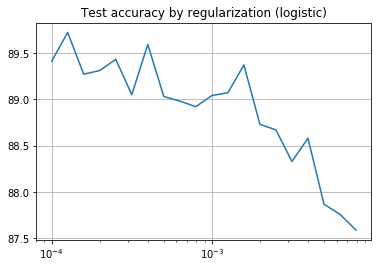

In [46]:
from matplotlib import pyplot as plt
plt.semilogx(reg_vals, acc_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [48]:
# Neural Network
batch_size = 128
n_hidden = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, n_hidden]))
    biases1 = tf.Variable(tf.zeros([n_hidden]))
    weights2 = tf.Variable(
        tf.truncated_normal([n_hidden, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation
    hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(hidden, weights2) + biases2
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation and test data
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), 
                                              weights2) + biases2)

In [52]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 2 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 370.531952
Minibatch accuracy: 3.9%
Validation accuracy: 22.8%
Minibatch loss at step 2: 1350.793091
Minibatch accuracy: 33.6%
Validation accuracy: 38.3%
Minibatch loss at step 4: 339.455444
Minibatch accuracy: 57.8%
Validation accuracy: 64.8%
Minibatch loss at step 6: 90.703896
Minibatch accuracy: 70.3%
Validation accuracy: 71.5%
Minibatch loss at step 8: 23.779957
Minibatch accuracy: 85.2%
Validation accuracy: 74.9%
Minibatch loss at step 10: 56.901497
Minibatch accuracy: 87.5%
Validation accuracy: 74.2%
Minibatch loss at step 12: 37.737587
Minibatch accuracy: 88.3%
Validation accuracy: 74.9%
Minibatch loss at step 14: 9.367664
Minibatch accuracy: 91.4%
Validation accuracy: 75.7%
Minibatch loss at step 16: 7.330304
Minibatch accuracy: 96.9%
Validation accuracy: 75.5%
Minibatch loss at step 18: 19.580494
Minibatch accuracy: 99.2%
Validation accuracy: 76.1%
Minibatch loss at step 20: 0.000001
Minibatch accuracy: 100.0%
Validation accuracy: 76.2%
Mi

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [53]:
# Neural Network
batch_size = 128
n_hidden = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, n_hidden]))
    biases1 = tf.Variable(tf.zeros([n_hidden]))
    weights2 = tf.Variable(
        tf.truncated_normal([n_hidden, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation
    hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(hidden, 0.5)
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation and test data
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), 
                                              weights2) + biases2)

In [54]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = step % num_batches
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 2 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 421.579651
Minibatch accuracy: 10.2%
Validation accuracy: 24.7%
Minibatch loss at step 2: 1405.446045
Minibatch accuracy: 34.4%
Validation accuracy: 37.9%
Minibatch loss at step 4: 319.498474
Minibatch accuracy: 65.6%
Validation accuracy: 57.0%
Minibatch loss at step 6: 55.871067
Minibatch accuracy: 82.0%
Validation accuracy: 58.1%
Minibatch loss at step 8: 27.072853
Minibatch accuracy: 93.0%
Validation accuracy: 61.0%
Minibatch loss at step 10: 43.429752
Minibatch accuracy: 89.8%
Validation accuracy: 63.0%
Minibatch loss at step 12: 0.394500
Minibatch accuracy: 97.7%
Validation accuracy: 65.5%
Minibatch loss at step 14: 7.298527
Minibatch accuracy: 95.3%
Validation accuracy: 63.9%
Minibatch loss at step 16: 2.784857
Minibatch accuracy: 96.9%
Validation accuracy: 65.4%
Minibatch loss at step 18: 6.877446
Minibatch accuracy: 98.4%
Validation accuracy: 66.6%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 66.9%
Min

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [56]:
# trying a 2 layered neural net
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    logits = tf.matmul(lay2_train, weights3) + biases3
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [58]:
num_steps = 9001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.296391
Minibatch accuracy: 7.8%
Validation accuracy: 33.7%
Minibatch loss at step 500: 1.116970
Minibatch accuracy: 80.5%
Validation accuracy: 85.0%
Minibatch loss at step 1000: 0.900054
Minibatch accuracy: 84.4%
Validation accuracy: 86.7%
Minibatch loss at step 1500: 0.639733
Minibatch accuracy: 89.8%
Validation accuracy: 88.0%
Minibatch loss at step 2000: 0.607548
Minibatch accuracy: 87.5%
Validation accuracy: 88.5%
Minibatch loss at step 2500: 0.513790
Minibatch accuracy: 91.4%
Validation accuracy: 88.7%
Minibatch loss at step 3000: 0.509243
Minibatch accuracy: 89.8%
Validation accuracy: 88.2%
Minibatch loss at step 3500: 0.507782
Minibatch accuracy: 92.2%
Validation accuracy: 89.3%
Minibatch loss at step 4000: 0.513298
Minibatch accuracy: 88.3%
Validation accuracy: 89.7%
Minibatch loss at step 4500: 0.498828
Minibatch accuracy: 88.3%
Validation accuracy: 89.5%
Minibatch loss at step 5000: 0.444852
Minibatch accuracy: 92.2%
Validation accuracy

__Conclusion__: Increasing a layer along with adding dropout helped in achieving a much better accuracy.